In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
import peaks_utility as psu
import s2_selection_utility as ssu
from multihist import Hist1d, Histdd
import time
import itertools
import os

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v0.12.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.12.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [4]:
run_id = '009746'
events = st.get_array(run_id,'event_basics')
peaks = st.get_array(run_id,'peak_basics')

In [5]:
run_id2 = '009748'
events2 = st.get_array(run_id2,'event_basics')
peaks2 = st.get_array(run_id2,'peak_basics')

In [32]:
def plot_drift_time(events, run_id, low = 0, high = 1200, low2 = 2, high2 = 5, binning = 500):
    phd = Histdd(events['drift_time']/1000, events['s2_area'],
                bins=(np.linspace(low, high, binning), np.logspace(low2, high2, binning)))
    phw = Histdd(events['drift_time']/1000, events['s2_range_50p_area'],
                bins=(np.linspace(low, high, binning), np.logspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    phd.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    
    plt.figure(figsize=(12,6))
    phw.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')

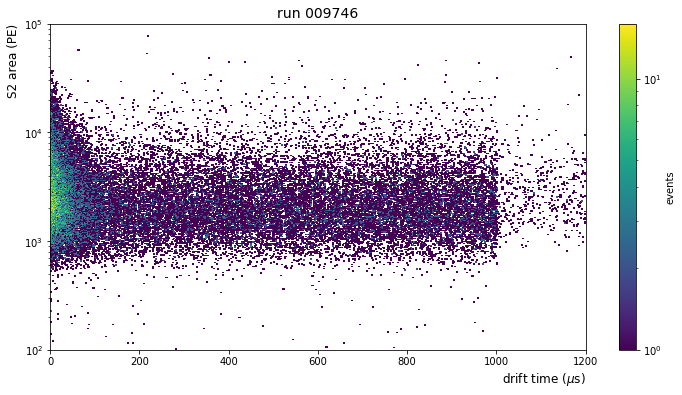

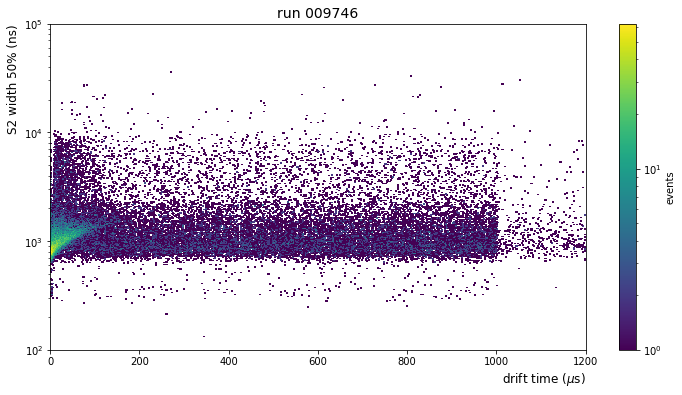

In [33]:
plot_drift_time(events, run_id)

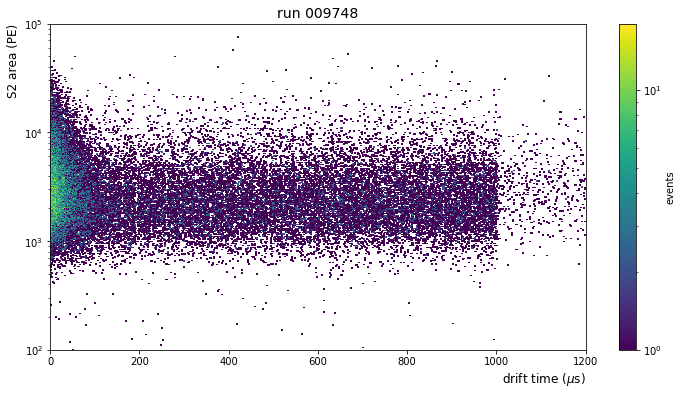

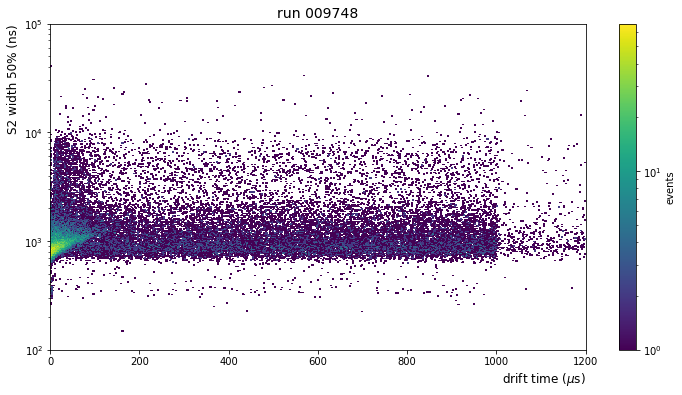

In [34]:
plot_drift_time(events2, run_id2)

In [35]:
def plot_drift_time_aft(events, run_id, low = 0, high = 1200, low2 = 0, high2 = 1, binning = 500):
    pha1 = Histdd(events['drift_time']/1000, events['s1_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    pha2 = Histdd(events['drift_time']/1000, events['s2_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    pha1.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S1 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    
    plt.figure(figsize=(12,6))
    pha2.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)

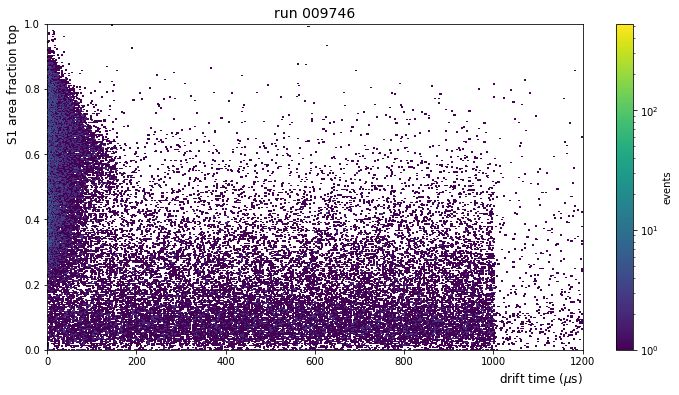

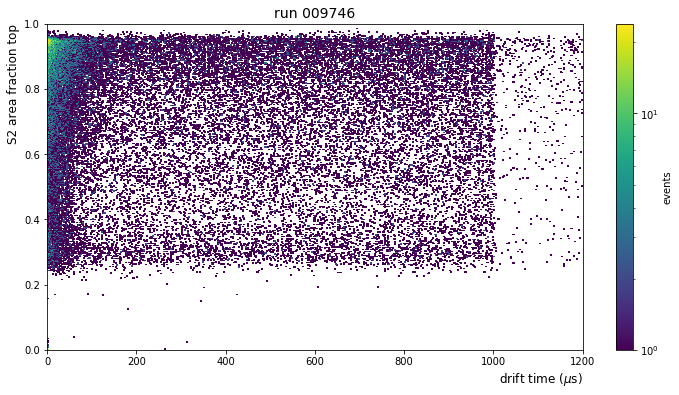

In [36]:
plot_drift_time_aft(events, run_id)

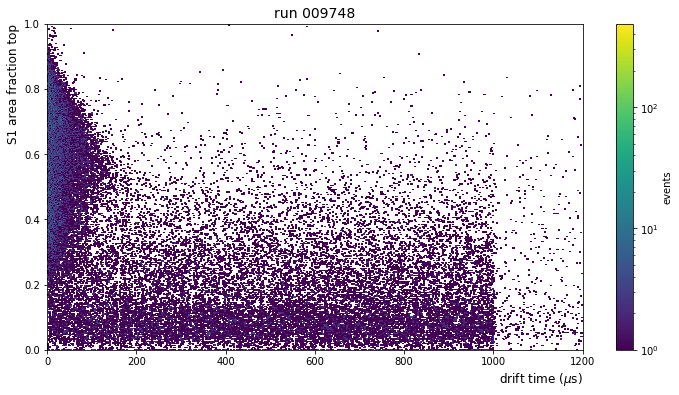

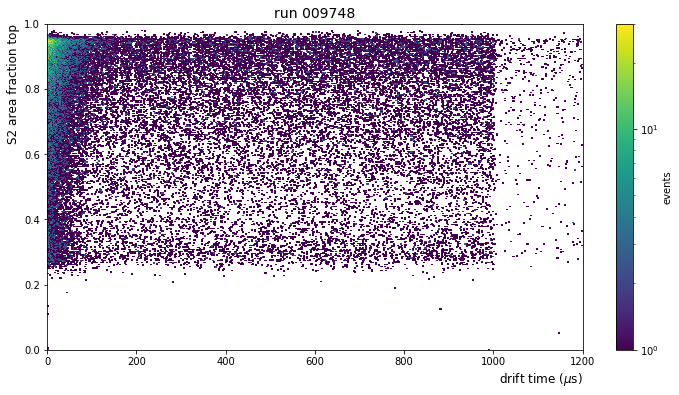

In [37]:
plot_drift_time_aft(events2, run_id2)

In [104]:
from scipy.optimize import curve_fit
def expo(t, tau, A):
    return A * np.exp(-t/tau)

def electron_lifetime(events, run_id):
    ev_sel = events[(events['s2_range_50p_area'] < 2500) & (events['s1_area'] > 100) & 
                            (events['drift_time']/1000 < 100) &  (events['s1_area_fraction_top'] > 0.15)]
    
    plt.figure(figsize=(12,6))
    t = np.linspace(2, 100, 100)
    mh = Histdd(ev_sel['drift_time']/1000, (ev_sel['s2_area']*(1 - ev_sel['s2_area_fraction_top'])),
                        bins=(dt_bins, np.logspace(1, 4.5, 100)))
    mean_s2 = mh.average(axis=1)
    mean_s2 = np.array(mean_s2)
    mh.plot(log_scale=True, cblabel='events')
    plt.plot(t[:len(mean_s2)],mean_s2,color='r', label='mean per drift time slice')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 bottom (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    plt.legend(fontsize=14)

    plt.figure(figsize=(12,6))
    plt.plot(t[1:],mean_s2,linestyle='steps-mid',label='mean values')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 bottom (PE)", ha='right', y=1,fontsize=12)
    popt, pcov = curve_fit(expo,t[:len(mean_s2)], mean_s2, p0=[100, 100])
    perr = np.sqrt(np.diag(pcov))
    plt.plot(t, expo(t, *popt), label=f'fit: ${popt[0]:.1f} \pm {perr[1]:.1f}~\mu$s lifetime')
    plt.title(f'run {run_id}',fontsize=14)
    plt.legend(fontsize=14)

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


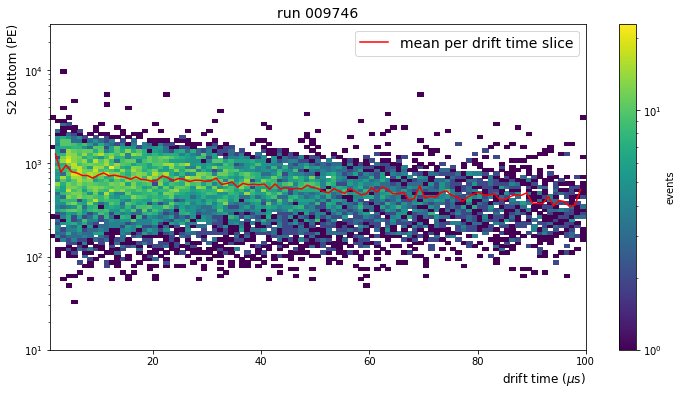

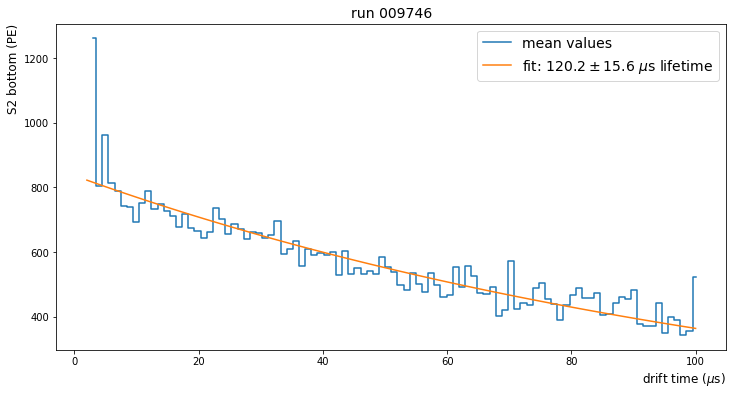

In [105]:
electron_lifetime(events, run_id)

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


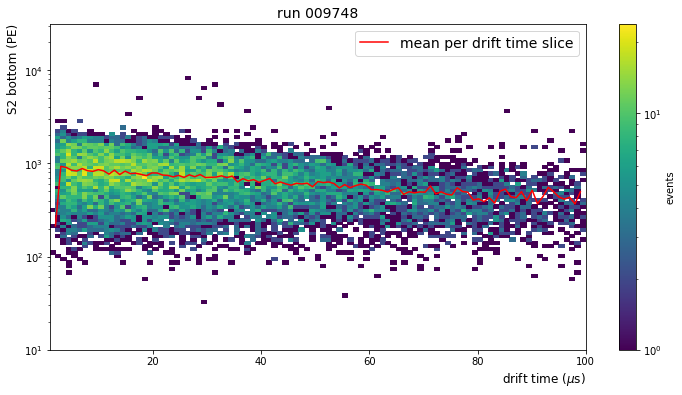

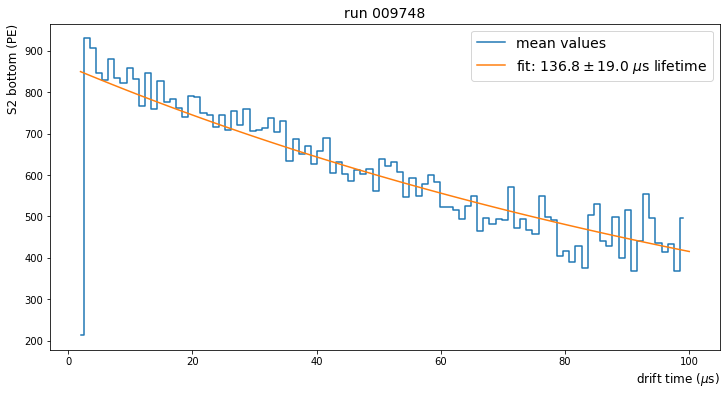

In [103]:
electron_lifetime(events2, run_id2)